## 1. Tree-Based Methods

Import packages

In [ ]:
pip install proc

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import proc
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

### (a) Download the APS Failure data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (b) Data Preparation

#### (i) Research what types of techniques are usually used

Deletion: deleting columns or rows with missing values
Imputation: replacing missing values with
- mean/med/mode
- predictive algorithms
- forward/backward fill

In [ ]:
#use imputation to replace with mean
trainingSet = pd.read_csv('/content/drive/My Drive/HW6Data/aps_failure_training_set.csv', skiprows=20)
testSet = pd.read_csv('/content/drive/My Drive/HW6Data/aps_failure_test_set.csv', skiprows=20)

#impute
trainingSet_numeric = trainingSet.apply(pd.to_numeric, errors='coerce')
testSet_numeric = testSet.apply(pd.to_numeric, errors='coerce')

trainingSet_imputed = trainingSet_numeric.fillna(trainingSet.mean(numeric_only=True))
testSet_imputed = testSet_numeric.fillna(testSet.mean(numeric_only=True))

#check for missing values
print("Missing values in trainingSet_imputed:")
print(trainingSet_imputed.isnull().sum())
print("\nMissing values in testSet_imputed:")
print(testSet_imputed.isnull().sum())

Missing values in trainingSet_imputed:
class     60000
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
          ...  
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int64

Missing values in testSet_imputed:
class     16000
aa_000        0
ab_000    12363
ac_000      926
ad_000     3981
          ...  
ee_007      192
ee_008      192
ee_009      192
ef_000      762
eg_000      762
Length: 171, dtype: int64


In [ ]:
#add files to drive
imputed_training_set_path = '/content/drive/My Drive/HW6Data/aps_failure_training_set_imputed.csv'
imputed_test_set_path = '/content/drive/My Drive/HW6Data/aps_failure_test_set_imputed.csv'

trainingSet_imputed.to_csv(imputed_training_set_path, index=False)
testSet_imputed.to_csv(imputed_test_set_path, index=False)

#### (ii) Calculate the coefficient of variation

In [ ]:
cv_list = {}

# Iterate over each feature
for col in trainingSet_imputed.columns:
    #calc mean and standard deviation
    mean = trainingSet_imputed[col].mean()
    std = trainingSet_imputed[col].std()

    #calc cv
    if mean != 0:
        cv = std / mean
        cv_list[col] = cv

#print cv for each feature
for feature, cv in cv_list.items():
    print(f"Feature '{feature}': Coefficient of Variation = {cv}")

Feature 'class': Coefficient of Variation = nan
Feature 'aa_000': Coefficient of Variation = 2.4509375779439706
Feature 'ab_000': Coefficient of Variation = 4.878039772408546
Feature 'ac_000': Coefficient of Variation = 2.232705262176664
Feature 'ad_000': Coefficient of Variation = 211.96241689097636
Feature 'ae_000': Coefficient of Variation = 23.689732132576104
Feature 'af_000': Coefficient of Variation = 19.060241033871275
Feature 'ag_000': Coefficient of Variation = 92.39667731467539
Feature 'ag_001': Coefficient of Variation = 35.051500729731565
Feature 'ag_002': Coefficient of Variation = 17.46708979280521
Feature 'ag_003': Coefficient of Variation = 8.598263633448965
Feature 'ag_004': Coefficient of Variation = 5.431938189898975
Feature 'ag_005': Coefficient of Variation = 2.9435982560396705
Feature 'ag_006': Coefficient of Variation = 2.3581503555111136
Feature 'ag_007': Coefficient of Variation = 2.849462399448585
Feature 'ag_008': Coefficient of Variation = 6.189289406182825


#### (iii) Make scatter plots and box plots

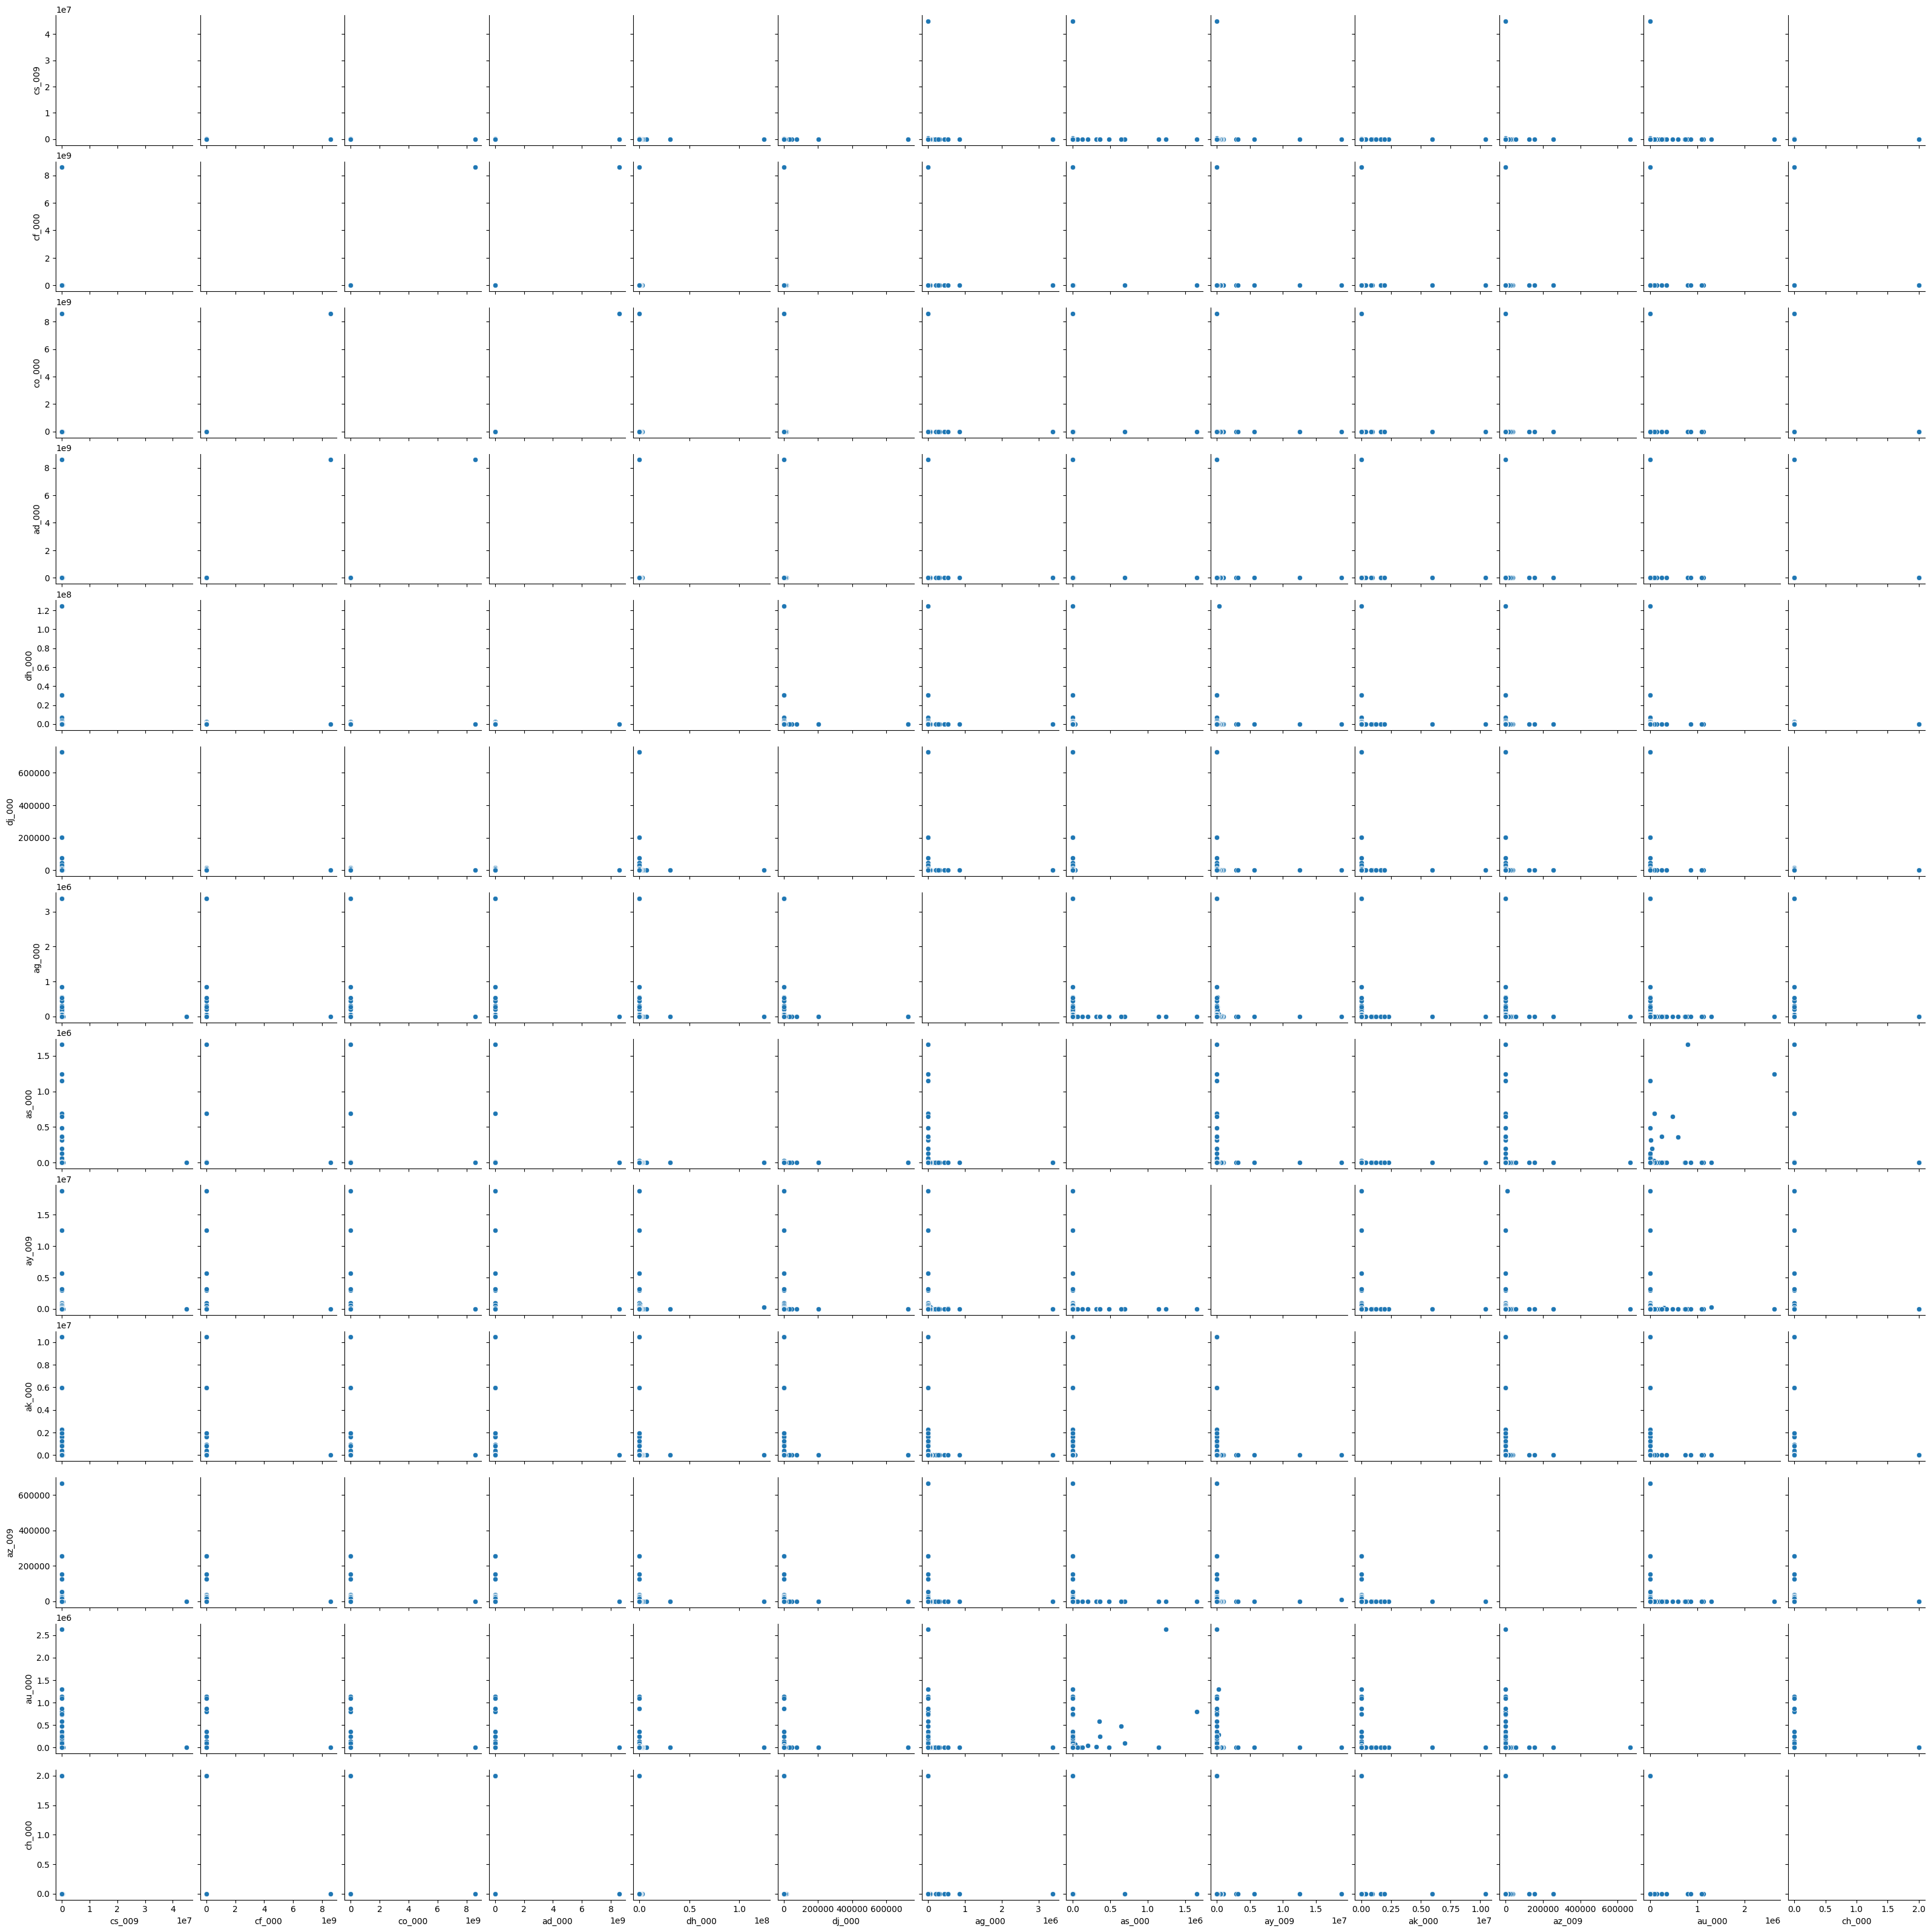

In [ ]:
cv_series = pd.Series(cv_list)
selected_features = cv_series.nlargest(int(np.sqrt(170))).index
sns.pairplot(data=trainingSet_imputed[selected_features],  diag_kind='none')
plt.show()

The scatter plots indicate relationships including linearity, outliers, and correlation among features however it is difficult to draw conclusions solely based on the scatter plots.

#### (iv) Is this data set imbalanced?

In [ ]:
#calc counts
positive_count = (trainingSet['class'] == 'pos').sum()
negative_count = (trainingSet['class'] == 'neg').sum()

#print counts
print("Number of positive instances:", positive_count)
print("Number of negative instances:", negative_count)


Number of positive instances: 1000
Number of negative instances: 59000


The dataset is highly imbalanced as the negative class instances greatly outnumner the positive class instances.

### (c) Train a random forest

In [ ]:
#define train and test
X_train = trainingSet_imputed.drop(columns=['class'])
y_train = trainingSet['class']
X_test = testSet_imputed.drop(columns=['class'])
y_test = testSet['class']

#impute
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

#train random forest
rf_classifier = RandomForestClassifier(oob_score=True)
rf_classifier.fit(X_train_imputed, y_train)

#predict
y_train_pred = rf_classifier.predict(X_train_imputed)
y_test_pred = rf_classifier.predict(X_test_imputed)



Test Error: 0.007937500000000042
Confusion Matrix (Training Set):
[[59000     0]
 [    0  1000]]
Confusion Matrix (Test Set):
[[15607    18]
 [  109   266]]
ROC AUC (Training Set): 1.0
ROC AUC (Test Set): 0.8540906666666667
Misclassification Rate (Training Set): 0.0
Misclassification Rate (Test Set): 0.007937500000000042


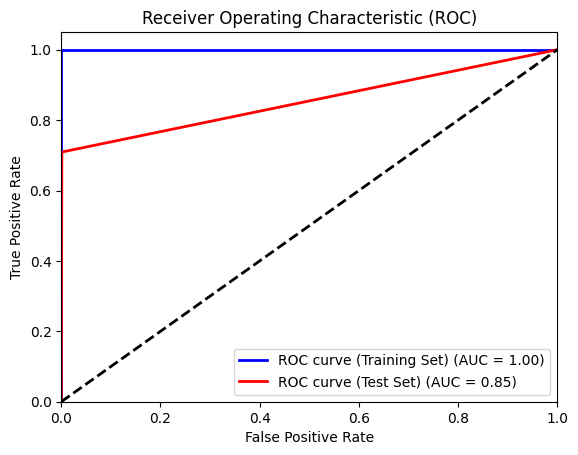

In [ ]:
#confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

#convert pos/neg to 1/0
y_train_binary = y_train.replace({'neg': 0, 'pos': 1})
y_test_binary = y_test.replace({'neg': 0, 'pos': 1})
y_train_pred_binary = np.where(y_train_pred == 'pos', 1, 0)
y_test_pred_binary = np.where(y_test_pred == 'pos', 1, 0)

#check type compatibility
y_train_binary = y_train_binary.astype(np.int64)
y_train_pred_binary = y_train_pred_binary.astype(np.int64)

#calc roc cuve and auc
fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_train_pred_binary)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_test_pred_binary)
roc_auc_test = auc(fpr_test, tpr_test)

#misclassification rate for training and test
misclassification_train = 1 - accuracy_score(y_train, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)

test_error = 1 - accuracy_score(y_test, y_test_pred)
print("Test Error:", test_error)

#print results
print("Confusion Matrix (Training Set):")
print(cm_train)
print("Confusion Matrix (Test Set):")
print(cm_test)
print("ROC AUC (Training Set):", roc_auc_train)
print("ROC AUC (Test Set):", roc_auc_test)
print("Misclassification Rate (Training Set):", misclassification_train)
print("Misclassification Rate (Test Set):", misclassification_test)

#roc curve
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (Training Set) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (Test Set) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#out of bag error
oob_error = 1 - rf_classifier.oob_score_
print("Out-of-Bag Error Estimate:", oob_error)

#test error
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)
test_error = misclassification_test
print("Test Error:", test_error)

Out-of-Bag Error Estimate: 0.006116666666666659
Test Error: 0.007937500000000042


Both errors are low indicating that the classifier works well on unseen data. The test error is slightly higher which can be due to the OOB error estimation method.


### (d) Research class imbalance in random forest

Class imbalance can be addressed using class weight balancing by giving higher weights to the minority class samples during the training process.

In [ ]:
rf_classifier_balanced = RandomForestClassifier(oob_score=True, class_weight='balanced')
rf_classifier_balanced.fit(X_train_imputed, y_train)


RandomForestClassifier(class_weight='balanced', oob_score=True)

Confusion Matrix (Training Set Balanced):
[[59000     0]
 [    1   999]]
Confusion Matrix (Test Set Balanced):
[[15612    13]
 [  159   216]]
ROC AUC (Training Set Balanced): 0.9995
ROC AUC (Test Set Balanced): 0.787584
Misclassification Rate (Training Set Balanced): 1.666666666666483e-05
Misclassification Rate (Test Set Balanced): 0.010750000000000037


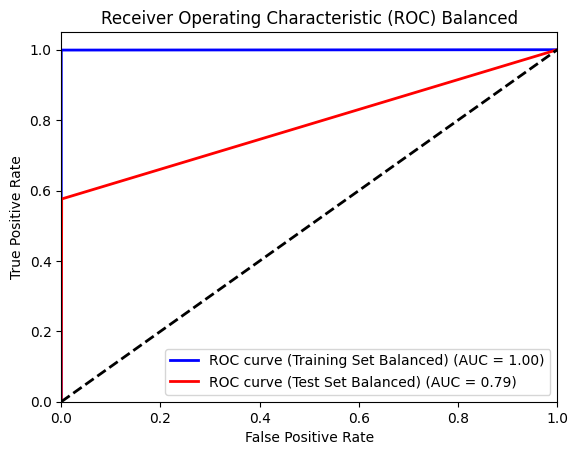

In [ ]:
#pred on train and test
y_train_pred_balanced = rf_classifier_balanced.predict(X_train_imputed)
y_test_pred_balanced = rf_classifier_balanced.predict(X_test_imputed)

#confusion matries
cm_train_balanced = confusion_matrix(y_train, y_train_pred_balanced)
cm_test_balanced = confusion_matrix(y_test, y_test_pred_balanced)

#convert pos/neg to 1/0
y_train_binary_balanced = y_train.replace({'neg': 0, 'pos': 1})
y_test_binary_balanced = y_test.replace({'neg': 0, 'pos': 1})

y_train_pred_binary_balanced = np.where(y_train_pred_balanced == 'pos', 1, 0)
y_test_pred_binary_balanced = np.where(y_test_pred_balanced == 'pos', 1, 0)

#check type compatibility
y_train_binary_balanced = y_train_binary_balanced.astype(np.int64)
y_train_pred_binary_balanced = y_train_pred_binary_balanced.astype(np.int64)

#roc curve and AUC
fpr_train_balanced, tpr_train_balanced, _ = roc_curve(y_train_binary_balanced, y_train_pred_binary_balanced)
roc_auc_train_balanced = auc(fpr_train_balanced, tpr_train_balanced)

fpr_test_balanced, tpr_test_balanced, _ = roc_curve(y_test_binary_balanced, y_test_pred_binary_balanced)
roc_auc_test_balanced = auc(fpr_test_balanced, tpr_test_balanced)

#misclassification rate
misclassification_train_balanced = 1 - accuracy_score(y_train, y_train_pred_balanced)
misclassification_test_balanced = 1 - accuracy_score(y_test, y_test_pred_balanced)

#print results
print("Confusion Matrix (Training Set Balanced):")
print(cm_train_balanced)
print("Confusion Matrix (Test Set Balanced):")
print(cm_test_balanced)
print("ROC AUC (Training Set Balanced):", roc_auc_train_balanced)
print("ROC AUC (Test Set Balanced):", roc_auc_test_balanced)
print("Misclassification Rate (Training Set Balanced):", misclassification_train_balanced)
print("Misclassification Rate (Test Set Balanced):", misclassification_test_balanced)

#roc curve
plt.figure()
plt.plot(fpr_train_balanced, tpr_train_balanced, color='blue', lw=2, label='ROC curve (Training Set Balanced) (AUC = %0.2f)' % roc_auc_train_balanced)
plt.plot(fpr_test_balanced, tpr_test_balanced, color='red', lw=2, label='ROC curve (Test Set Balanced) (AUC = %0.2f)' % roc_auc_test_balanced)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Balanced')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#oob error
oob_error_balanced = 1 - rf_classifier_balanced.oob_score_

#test error
test_error_balanced = 1 - accuracy_score(y_test, y_test_pred_balanced)

#print results
print("Out-of-Bag Error Estimate (Balanced):", oob_error_balanced)
print("Test Error (Balanced):", test_error_balanced)

Out-of-Bag Error Estimate (Balanced): 0.007783333333333364
Test Error (Balanced): 0.010750000000000037


Overall the balanced model is better at handling class imbalance. This is indicated by the confusion matrices that show fewer misclassifications. The ROC AUC score for the test set is slightly lower in the balanced model compared to the unbalanced model indicating that the balanced model does not generalize as well to unseen data. The test error is higher in the balanced model compared to the unbalanced model indicating that the balanced model performs slightly worse on the test set.

### (e) XGBoost and Model Trees

In [ ]:
xgb_classifier = XGBClassifier(booster='gbtree', tree_method='hist', objective='binary:logistic', eval_metric='logloss')

In [ ]:
#cross validation to find best alpha
alpha_values_test = [1, 2, 3, 4]
cv_scores = []
for alpha in alpha_values_test:
    xgb_classifier.set_params(alpha=alpha)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(xgb_classifier, X_train_imputed, y_train_binary, cv=cv, scoring='roc_auc')
    cv_scores.append(scores.mean())

a = alpha_values_test[np.argmax(cv_scores)]

In [ ]:
print(a)

2


In [ ]:
#fit model
xgb_classifier.set_params(alpha=a)
xgb_classifier.fit(X_train_imputed, y_train_binary)

#predict
y_train_pred_binary = xgb_classifier.predict(X_train_imputed)
y_test_pred_binary = xgb_classifier.predict(X_test_imputed)

Confusion Matrix (Training Set):
[[59000     0]
 [    7   993]]
Confusion Matrix (Test Set):
[[15608    17]
 [   86   289]]
ROC AUC (Training Set): 0.9964999999999999
ROC AUC (Test Set): 0.8847893333333333


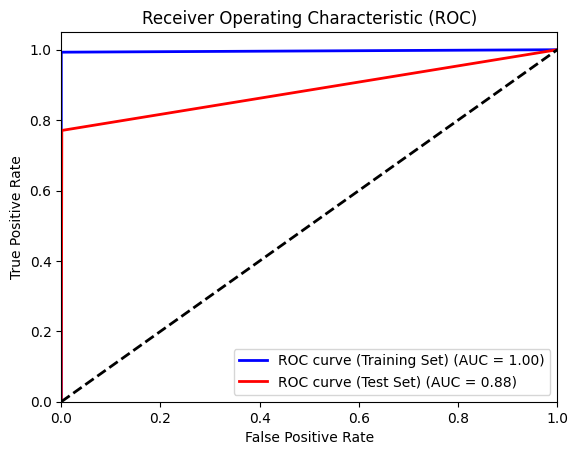

In [ ]:
#confusion matrix
conf_matrix_train = confusion_matrix(y_train_binary, y_train_pred_binary)
conf_matrix_test = confusion_matrix(y_test_binary, y_test_pred_binary)

#roc curve and auc
fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_train_pred_binary)
roc_auc_train = roc_auc_score(y_train_binary, y_train_pred_binary)

fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_test_pred_binary)
roc_auc_test = roc_auc_score(y_test_binary, y_test_pred_binary)

#print results
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)
print("Confusion Matrix (Test Set):")
print(conf_matrix_test)
print("ROC AUC (Training Set):", roc_auc_train)
print("ROC AUC (Test Set):", roc_auc_test)

#roc curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (Training Set) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (Test Set) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### (f) Use SMOTE to pre-process your data

In [ ]:
smote = SMOTE(random_state = 53)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train_binary)

XGBoost Model with SMOTE:
Accuracy: 0.9923125
Confusion Matrix:
[[15571    54]
 [   69   306]]
ROC AUC: 0.9062719999999999


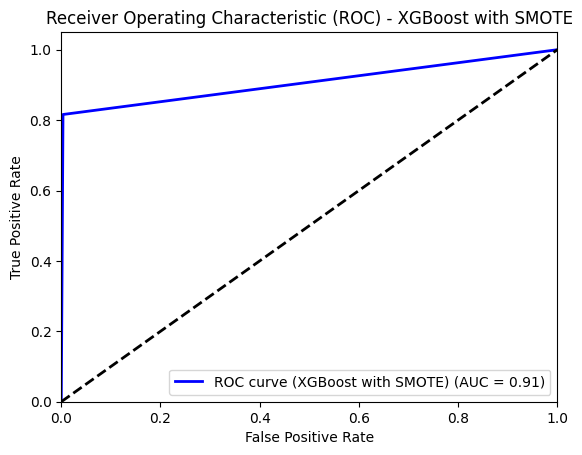

In [ ]:
#smote
xgb_classifier_smote = XGBClassifier(tree_method='hist', objective='binary:logistic', reg_alpha=a)
xgb_classifier_smote.fit(X_train_smote, y_train_smote)

#predict
y_test_pred_smote = xgb_classifier_smote.predict(X_test_imputed)

#calc metrics
accuracy_smote = accuracy_score(y_test_binary, y_test_pred_smote)
cm_smote = confusion_matrix(y_test_binary, y_test_pred_smote)
fpr_smote, tpr_smote, _ = roc_curve(y_test_binary, y_test_pred_smote)
roc_auc_smote = roc_auc_score(y_test_binary, y_test_pred_smote)

#print evaluation methods
print("XGBoost Model with SMOTE:")
print("Accuracy:", accuracy_smote)
print("Confusion Matrix:")
print(cm_smote)
print("ROC AUC:", roc_auc_smote)

#plot roc curve
plt.figure()
plt.plot(fpr_smote, tpr_smote, color='blue', lw=2, label='ROC curve (XGBoost with SMOTE) (AUC = %0.2f)' % roc_auc_smote)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost with SMOTE')
plt.legend(loc="lower right")
plt.show()